In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # suppress warnings

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
#from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

In [3]:
# Load the dataset 
file_name = "Resample_Data_Ordered.csv" 
df = pd.read_csv(file_name) 
df.head()

,signal_wrist_ACC_0,signal_wrist_ACC_1,signal_wrist_ACC_2,signal_wrist_BVP_0,signal_wrist_EDA_0,label,user
0,52.18750,13.56250,29.87500,32.057187,1.077074,0,S2
1,57.96875,1.37500,17.59375,-20.473437,0.203358,0,S2
2,63.06250,3.40625,-1.15625,-106.862813,0.203998,0,S2
3,63.09375,2.09375,-1.75000,123.484531,0.212007,0,S2
4,57.81250,0.03125,18.90625,-50.409844,0.229945,0,S2


In [4]:
df_filtered = df[df['label'].isin([0,1,2])]

In [5]:
# Compute ACC magnitude
df_filtered['acc_magnitude'] = np.sqrt(
    df_filtered['signal_wrist_ACC_0']**2 +
    df_filtered['signal_wrist_ACC_1']**2 +
    df_filtered['signal_wrist_ACC_2']**2
)

# Rolling features (5-second window example)
window = 5
df_filtered['acc_mag_mean5'] = df_filtered['acc_magnitude'].rolling(window).mean()
df_filtered['acc_mag_std5'] = df_filtered['acc_magnitude'].rolling(window).std()
df_filtered['bvp_mean5'] = df_filtered['signal_wrist_BVP_0'].rolling(window).mean()
df_filtered['eda_mean5'] = df_filtered['signal_wrist_EDA_0'].rolling(window).mean()

# Drop rows with NaNs created by rolling
df_filtered = df_filtered.dropna().reset_index(drop=True)

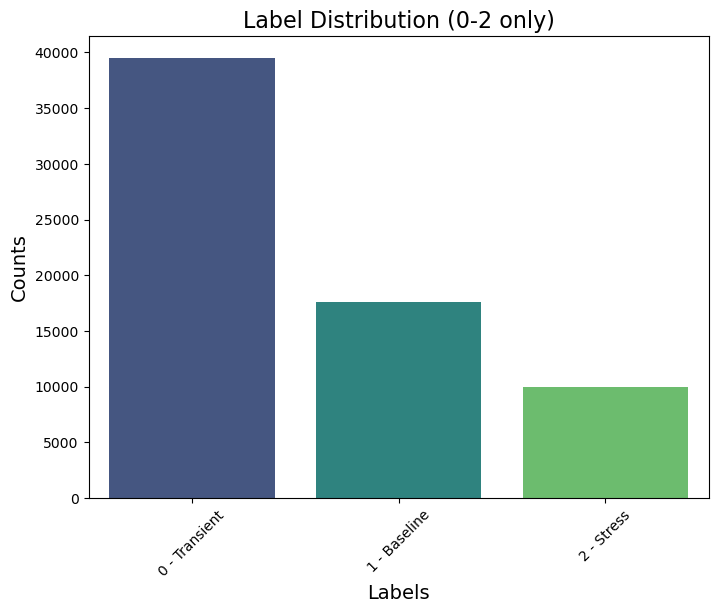

In [6]:
# Count labels after filtering
label_counts = df_filtered['label'].value_counts().sort_index()

# Map labels to meaningful names
label_mapping = {
    0: '0 - Transient',
    1: '1 - Baseline',
    2: '2 - Stress',
}

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    x=[label_mapping[i] for i in label_counts.index],
    y=label_counts.values,
    palette='viridis'
)

plt.title('Label Distribution (0-2 only)', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=45)
plt.show()

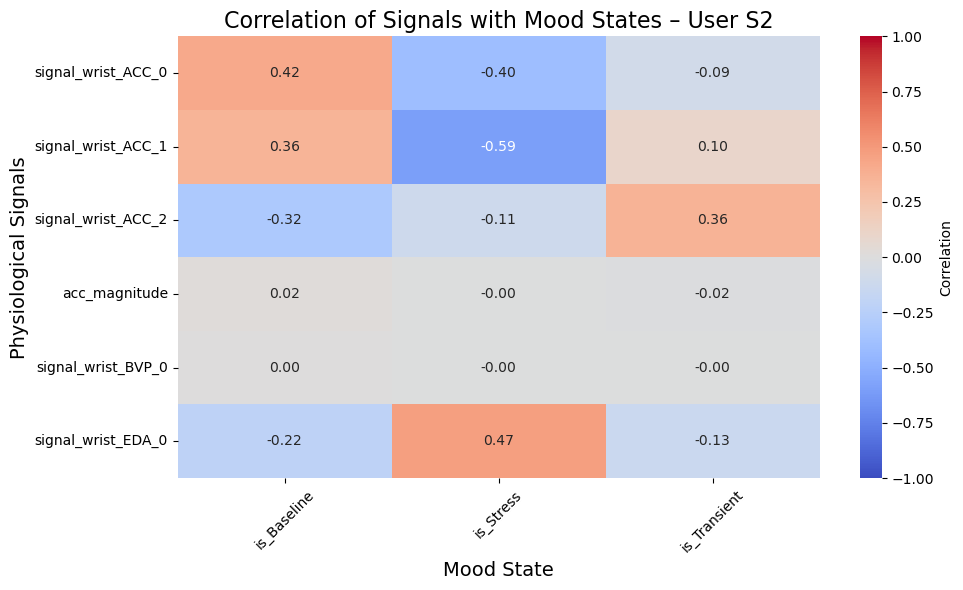

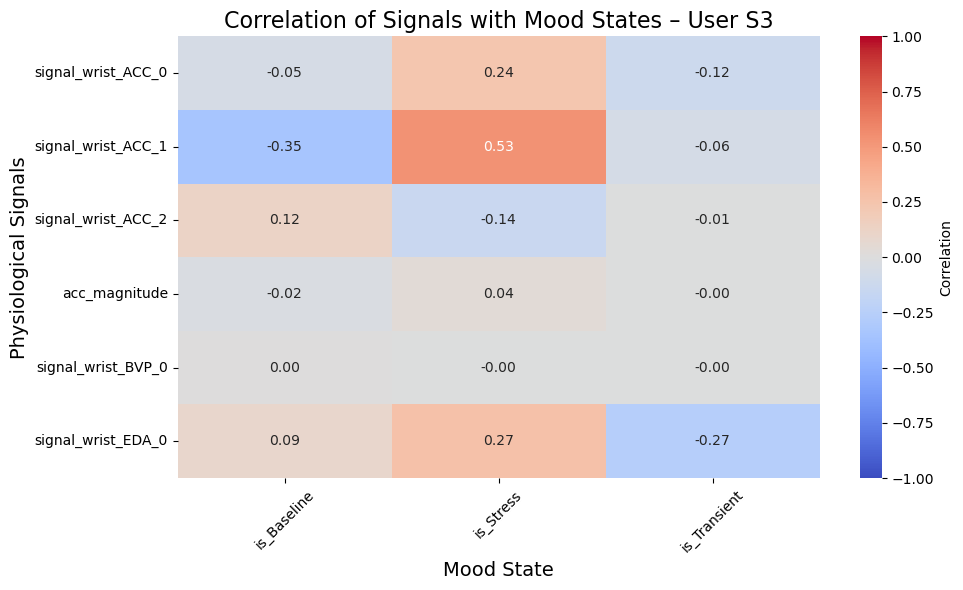

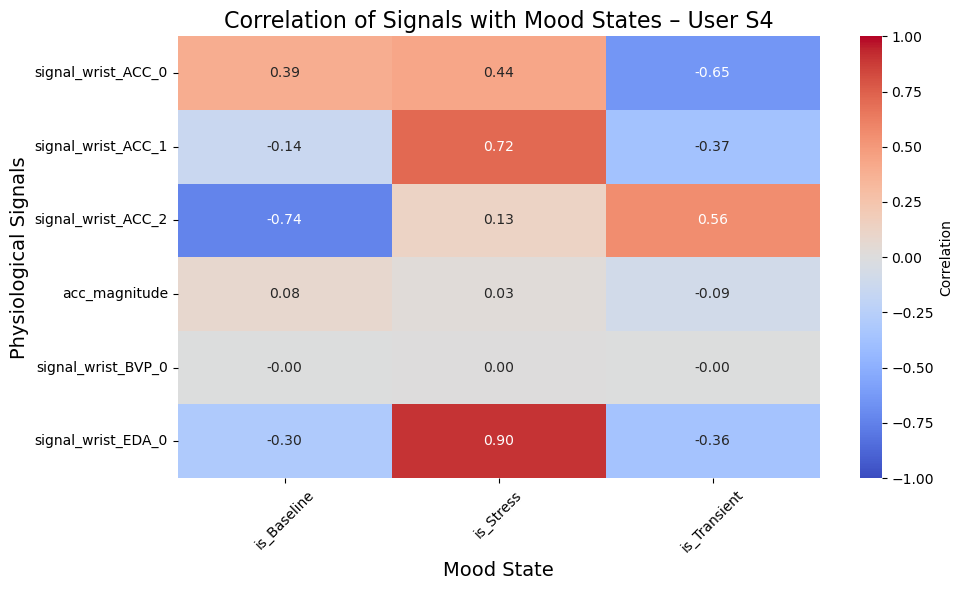

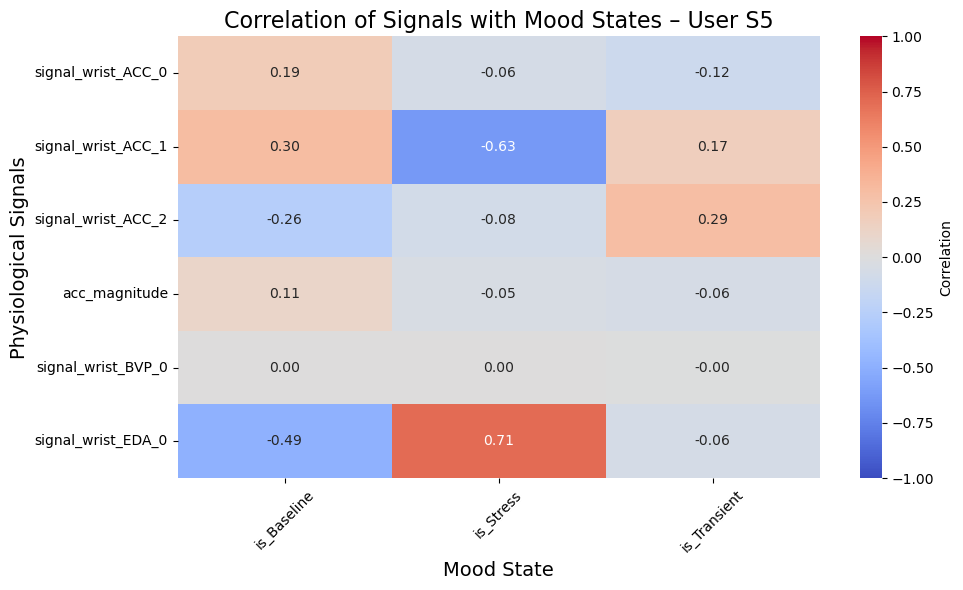

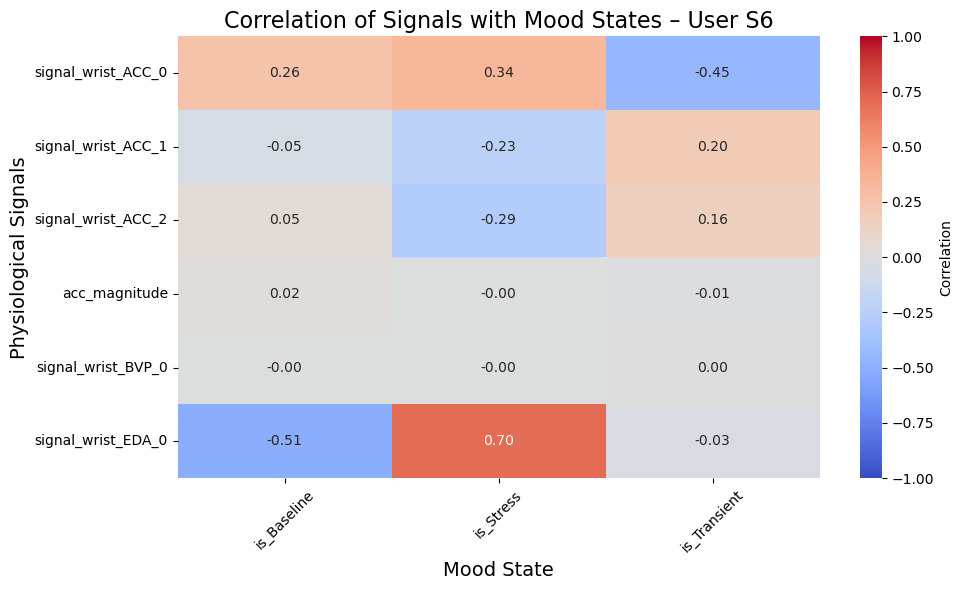

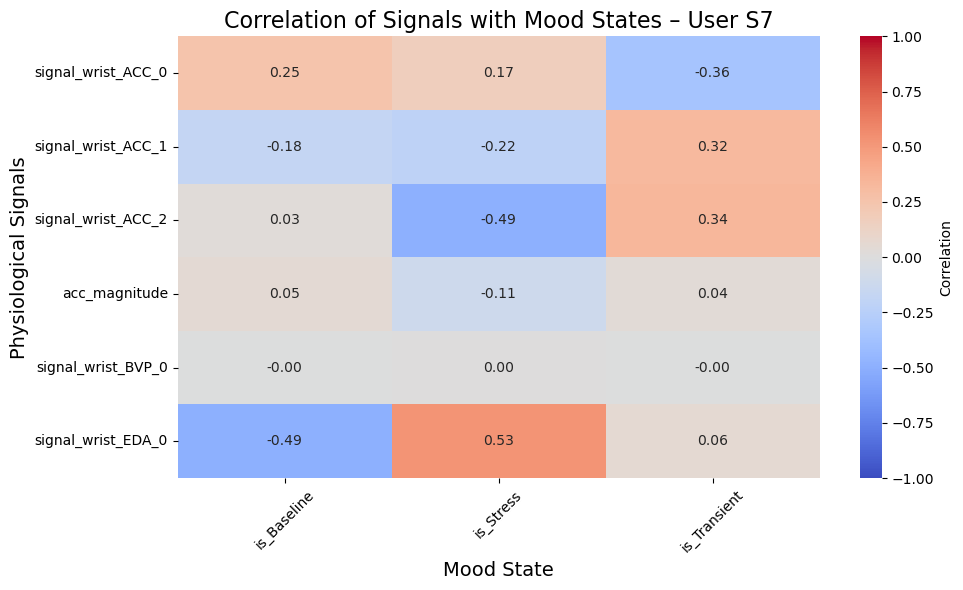

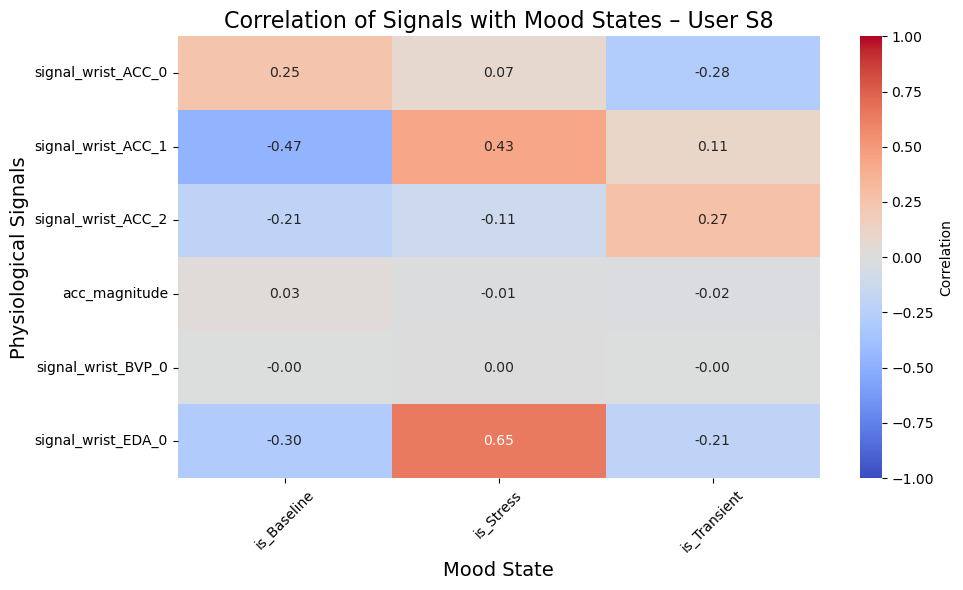

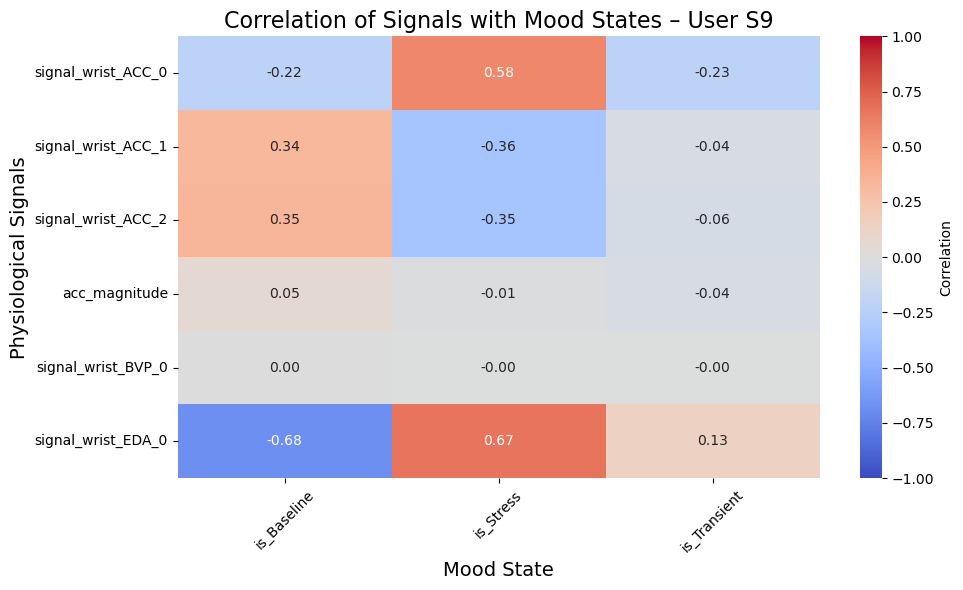

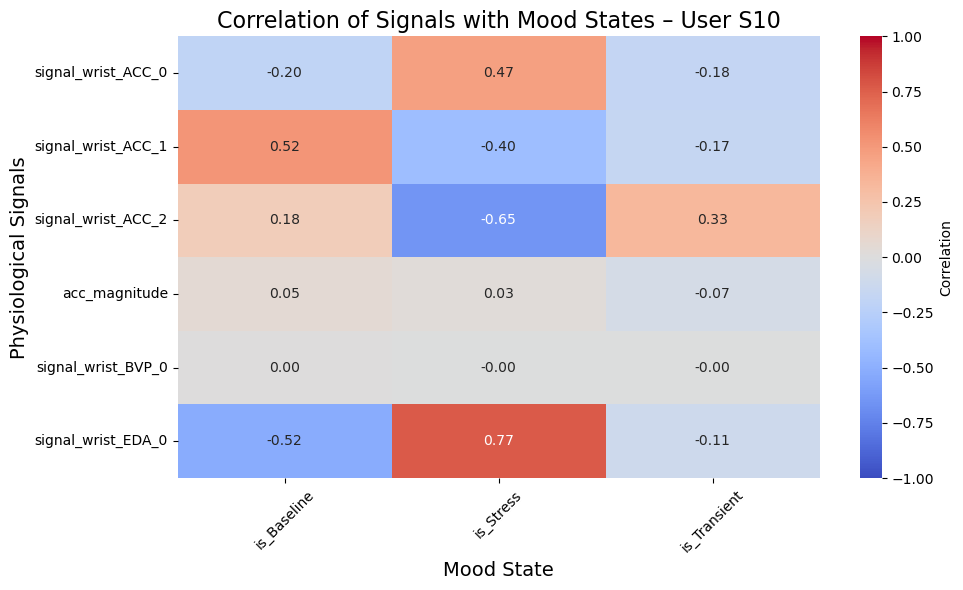

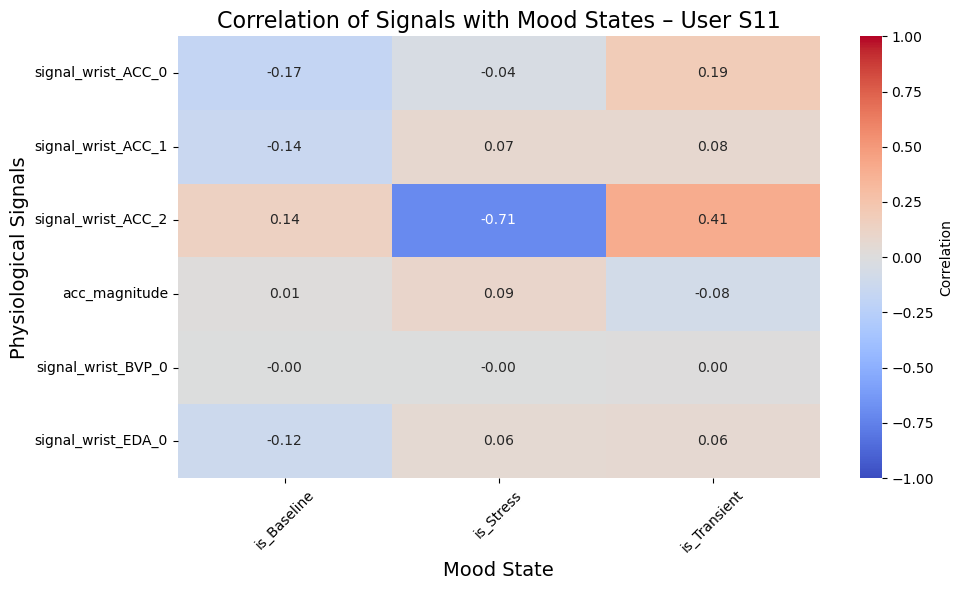

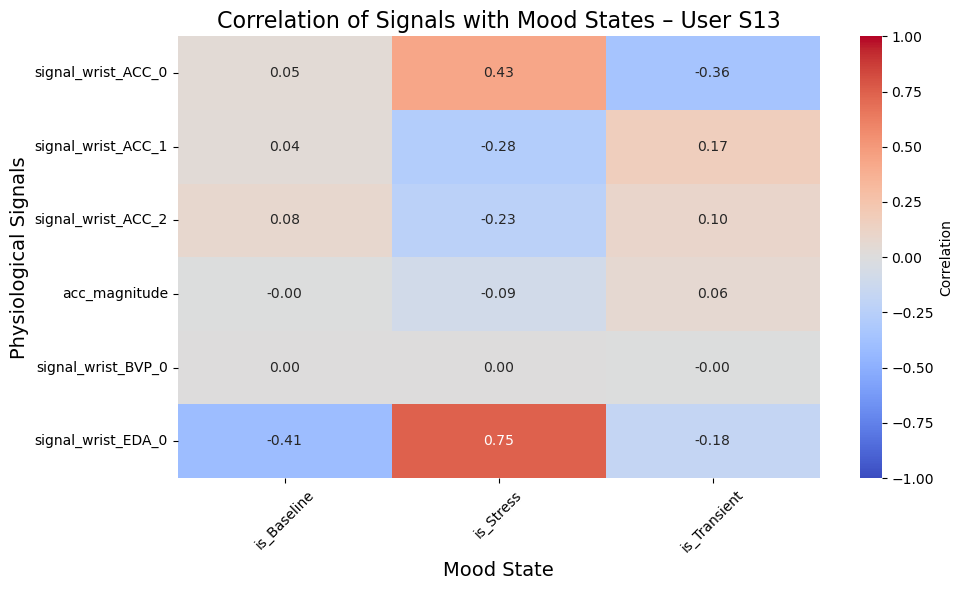

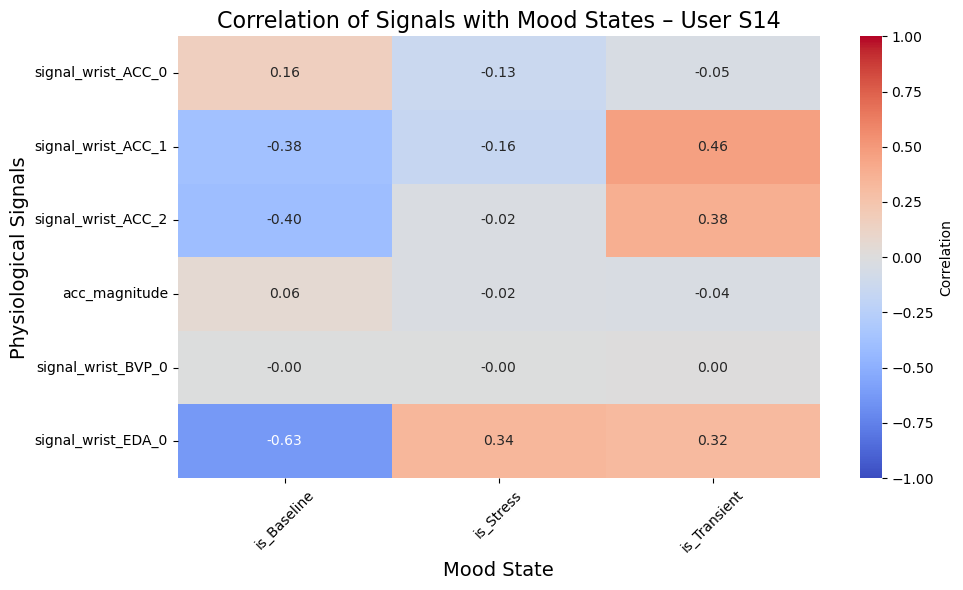

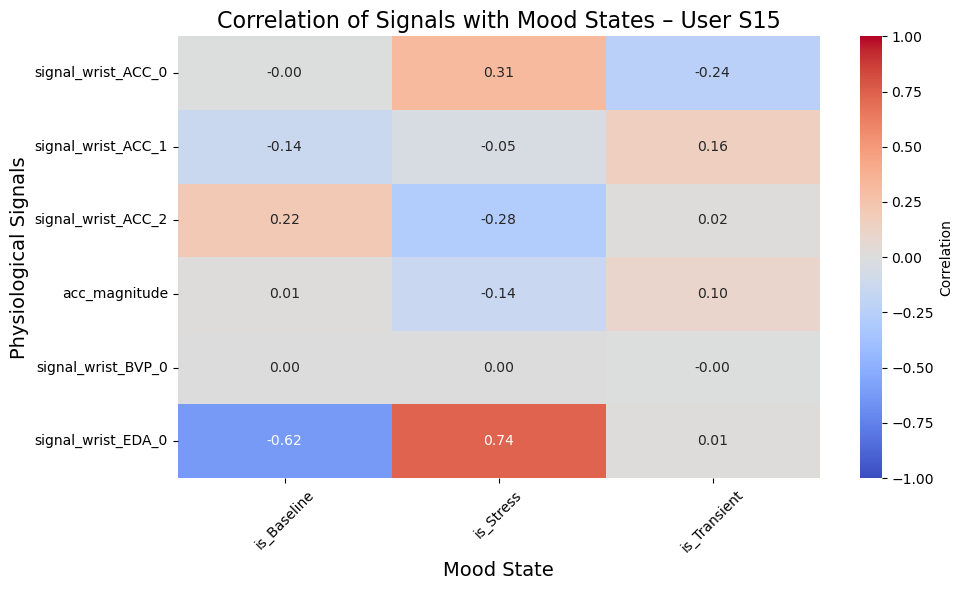

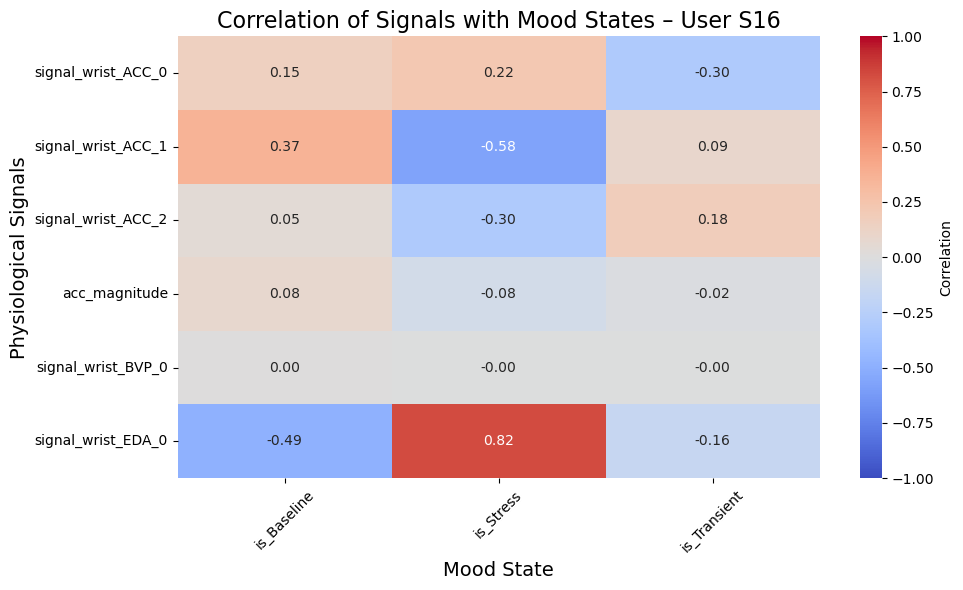

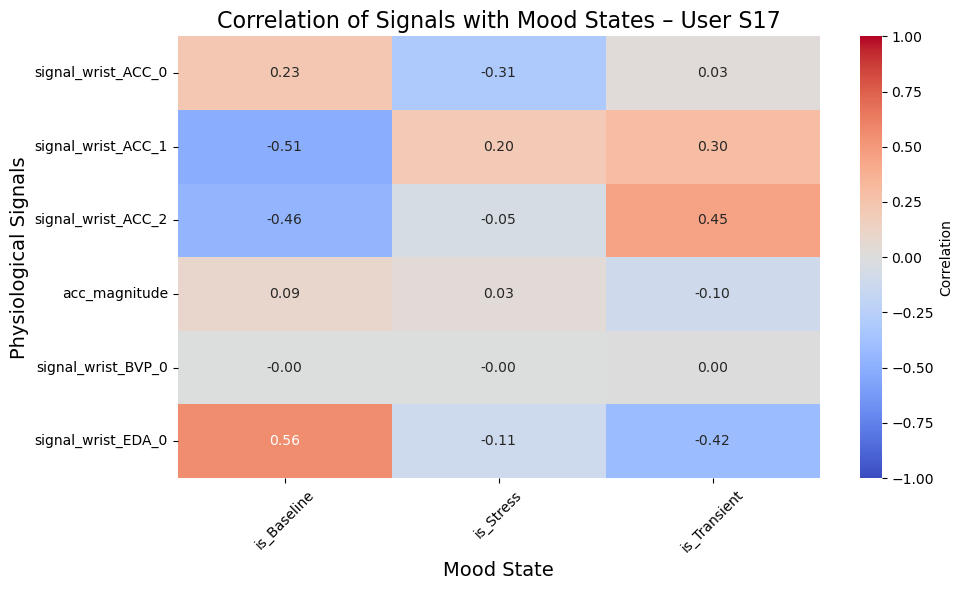

In [7]:
# Mood names
label_names = {
    0: 'Transient',
    1: 'Baseline',
    2: 'Stress',
}

# One-hot encode mood labels
df_filtered['mood_name'] = df_filtered['label'].map(label_names)
df_ohe = pd.get_dummies(df_filtered['mood_name'], prefix='is')

# Add one-hot mood columns
df_filtered = pd.concat([df_filtered, df_ohe], axis=1)

# Signals to analyze
signal_cols = [
    'signal_wrist_ACC_0',
    'signal_wrist_ACC_1',
    'signal_wrist_ACC_2',
    'acc_magnitude',
    'signal_wrist_BVP_0',
    'signal_wrist_EDA_0'
]

# Mood columns (binary)
mood_cols = df_ohe.columns.tolist()

# Unique users
users = df_filtered['user'].unique()

for user in users:
    df_user = df_filtered[df_filtered['user'] == user]

    # Compute correlation between signals and mood states
    corr_matrix = df_user[signal_cols + mood_cols].corr().loc[signal_cols, mood_cols]

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f",
                cmap="coolwarm", center=0, vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlation'})
    
    plt.title(f'Correlation of Signals with Mood States – User {user}', fontsize=16)
    plt.xlabel('Mood State', fontsize=14)
    plt.ylabel('Physiological Signals', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [8]:
feature_cols = [
    'acc_magnitude', 'acc_mag_mean5', 'acc_mag_std5',
    'signal_wrist_ACC_0', 'signal_wrist_ACC_1', 'signal_wrist_ACC_2',
    'signal_wrist_BVP_0', 'bvp_mean5',
    'signal_wrist_EDA_0', 'eda_mean5'
]

users = df_filtered['user'].unique()


--- LOUO: Testing on user S2 ---


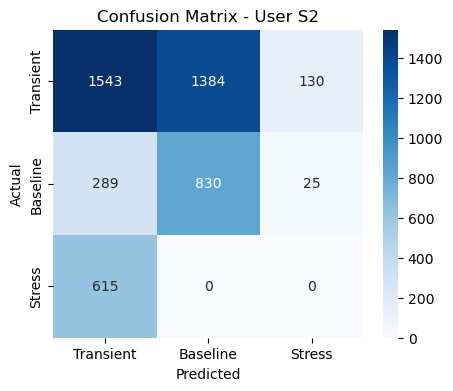


--- LOUO: Testing on user S3 ---


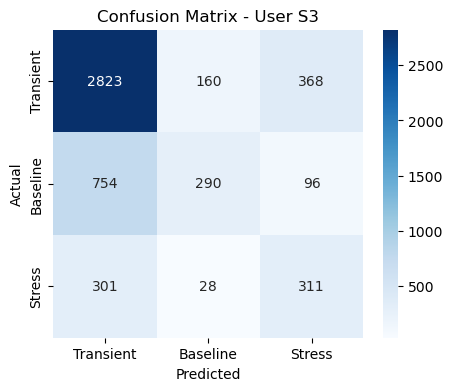


--- LOUO: Testing on user S4 ---


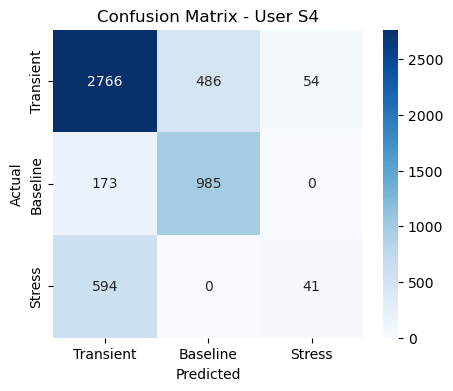


--- LOUO: Testing on user S5 ---


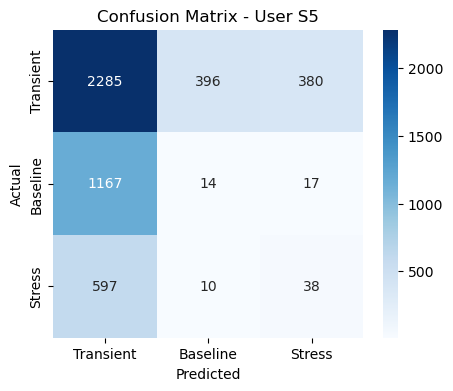


--- LOUO: Testing on user S6 ---


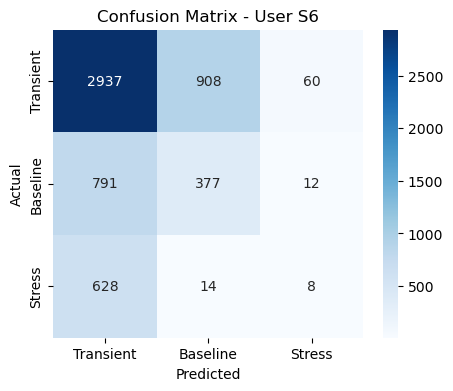


--- LOUO: Testing on user S7 ---


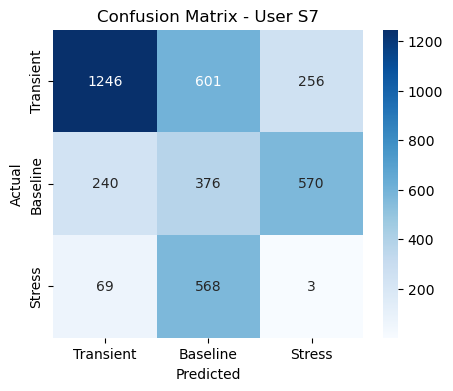


--- LOUO: Testing on user S8 ---


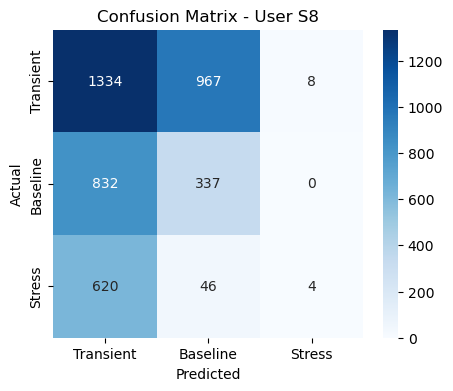


--- LOUO: Testing on user S9 ---


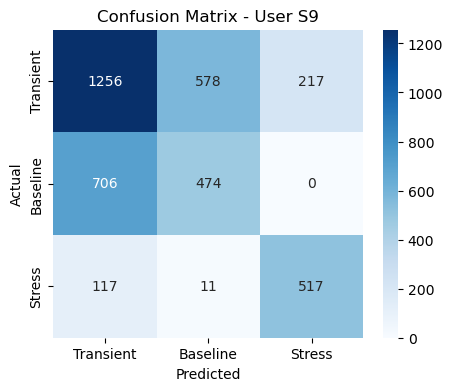


--- LOUO: Testing on user S10 ---


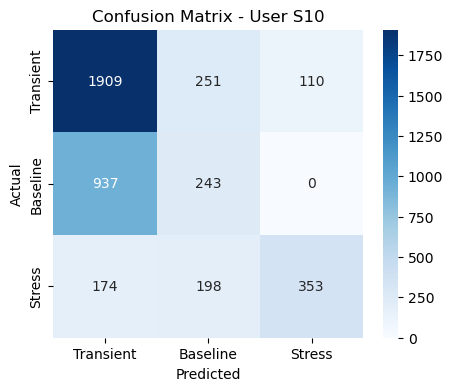


--- LOUO: Testing on user S11 ---


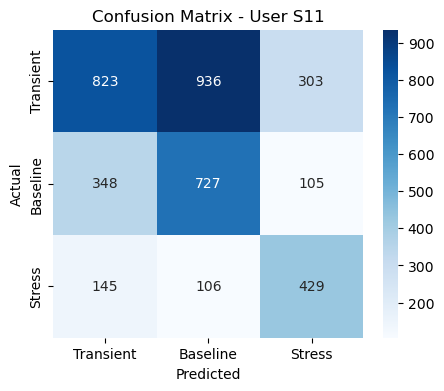


--- LOUO: Testing on user S13 ---


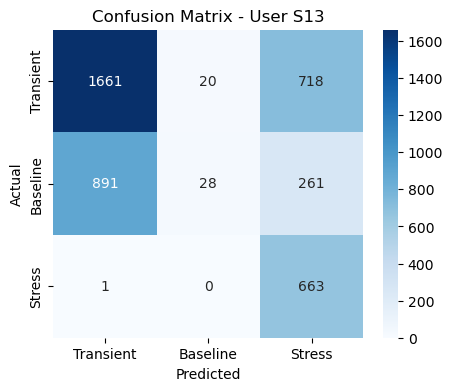


--- LOUO: Testing on user S14 ---


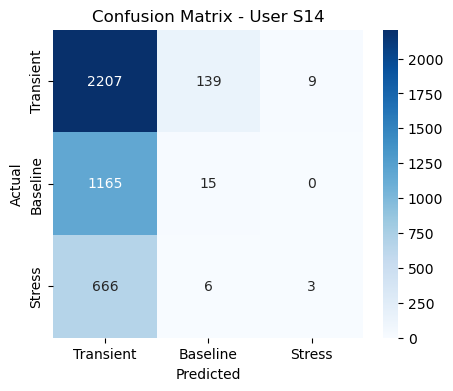


--- LOUO: Testing on user S15 ---


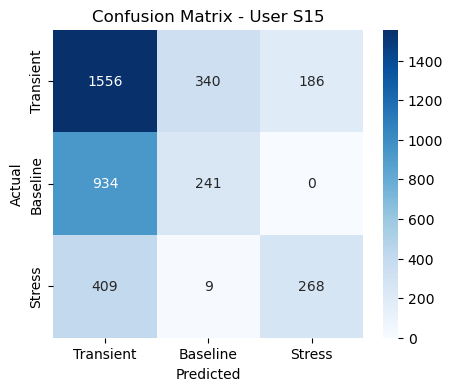


--- LOUO: Testing on user S16 ---


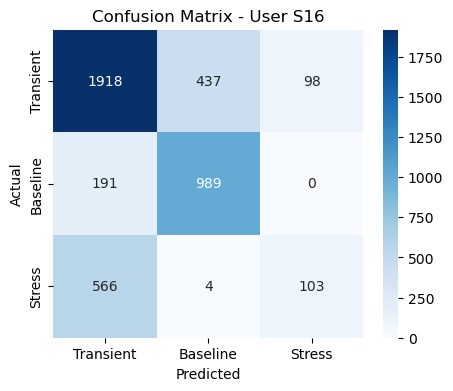


--- LOUO: Testing on user S17 ---


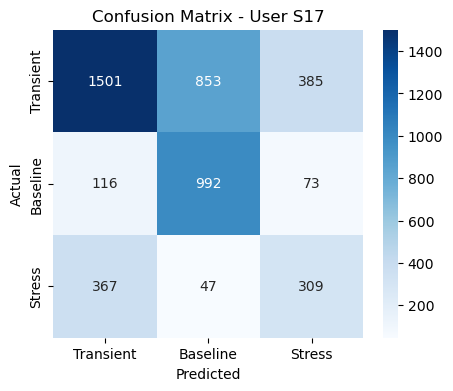

In [9]:
# ===============================
# LOUO EVALUATION
# ===============================
louo_reports = []

for test_user in users:
    print(f"\n--- LOUO: Testing on user {test_user} ---")
    
    # Split train/test by user
    df_train = df_filtered[df_filtered['user'] != test_user]
    df_test = df_filtered[df_filtered['user'] == test_user]

    X_train, y_train = df_train[feature_cols].values, df_train['label'].values
    X_test, y_test = df_test[feature_cols].values, df_test['label'].values

    # SMOTE on training set
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Standard scaling
    louo_scaler = StandardScaler()
    X_train_res = louo_scaler.fit_transform(X_train_res)
    X_test_scaled = louo_scaler.transform(X_test)

    # Train XGBoost
    louo_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    louo_model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = louo_model.predict(X_test_scaled)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=['Transient','Baseline','Stress'], output_dict=True)
    louo_reports.append(report)

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Transient','Baseline','Stress'],
                yticklabels=['Transient','Baseline','Stress'])
    plt.title(f'Confusion Matrix - User {test_user}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Clean up
    del louo_model, louo_scaler, X_train_res, X_test_scaled


In [10]:
# Compute weighted averages across all users
precision = np.mean([r['weighted avg']['precision'] for r in louo_reports])
recall    = np.mean([r['weighted avg']['recall'] for r in louo_reports])
f1        = np.mean([r['weighted avg']['f1-score'] for r in louo_reports])

print("LOUO-CV Results (Weighted Avg across all users):")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

LOUO-CV Results (Weighted Avg across all users):
Precision: 0.543
Recall:    0.558
F1-score:  0.527


In [11]:
# ===============================
# GENERAL MODEL TRAINING
# ===============================
# Choose users for training and testing manually
train_users = ['S2','S3','S4','S5','S6','S7','S8','S9','S10'] 
test_users = ['S11','S13','S14','S15','S16','S17']                   

df_train = df_filtered[df_filtered['user'].isin(train_users)]
df_test = df_filtered[df_filtered['user'].isin(test_users)]

X_train, y_train = df_train[feature_cols].values, df_train['label'].values
X_test, y_test = df_test[feature_cols].values, df_test['label'].values

# SMOTE + scale
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Train general XGBoost
general_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
general_model.fit(X_train_res, y_train_res)

# Evaluate
y_pred = general_model.predict(X_test_scaled)
print("\nGeneral model evaluation on test users:")
print(classification_report(y_test, y_pred, target_names=['Transient','Baseline','Stress']))



General model evaluation on test users:
              precision    recall  f1-score   support

   Transient       0.60      0.71      0.65     14090
    Baseline       0.50      0.36      0.42      7076
      Stress       0.42      0.35      0.38      4101

    accuracy                           0.55     25267
   macro avg       0.51      0.47      0.48     25267
weighted avg       0.54      0.55      0.54     25267




--- Personalized fine-tuning for user S11 ---


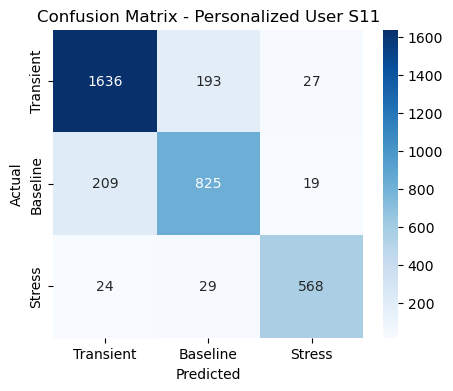


--- Personalized fine-tuning for user S13 ---


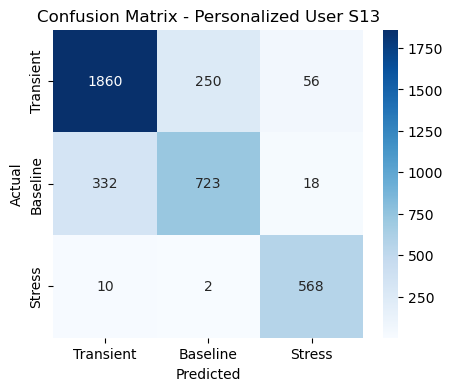


--- Personalized fine-tuning for user S14 ---


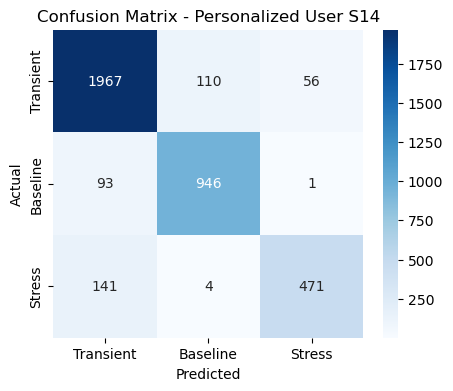


--- Personalized fine-tuning for user S15 ---


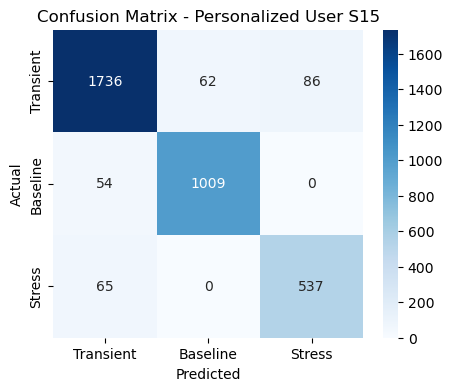


--- Personalized fine-tuning for user S16 ---


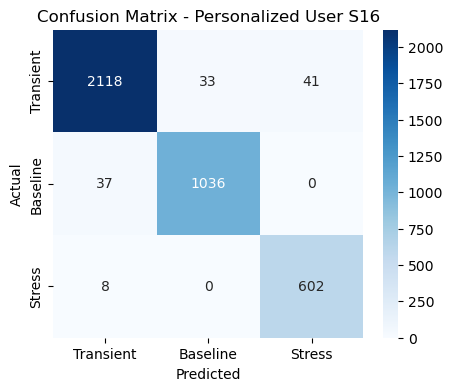


--- Personalized fine-tuning for user S17 ---


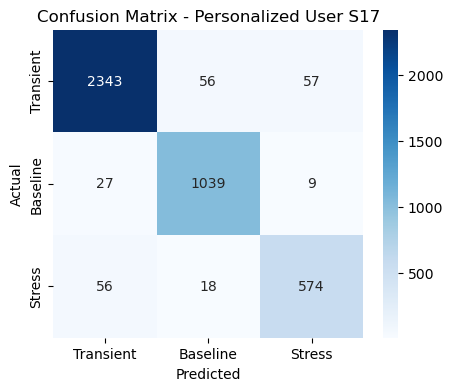

  user  accuracy  precision  f1_score
0  S11  0.858074   0.858024  0.858036
1  S13  0.825085   0.821788  0.822584
2  S14  0.893112   0.893080  0.892151
3  S15  0.924768   0.925191  0.924902
4  S16  0.969290   0.969646  0.969338
5  S17  0.946638   0.946800  0.946618


In [12]:
personalized_results = []

for test_user in test_users:
    print(f"\n--- Personalized fine-tuning for user {test_user} ---")
    
    df_user = df_test[df_test['user'] == test_user]
    
    fraction = 0.1  # 10% for fine-tuning
    df_finetune = df_user.sample(frac=fraction, random_state=42)
    df_eval = df_user.drop(df_finetune.index)

    X_finetune = scaler.transform(df_finetune[feature_cols].values)
    y_finetune = df_finetune['label'].values

    X_eval = scaler.transform(df_eval[feature_cols].values)
    y_eval = df_eval['label'].values

    # Fine-tune general model using xgb DMatrix
    dtrain_user = xgb.DMatrix(X_finetune, label=y_finetune)
    xgb_model = xgb.train(
        params={
            "objective": "multi:softmax",
            "num_class": 3,
            "eval_metric": "mlogloss",
            "seed": 42
        },
        dtrain=dtrain_user,
        num_boost_round=10,
        xgb_model=general_model.get_booster()
    )

    # Predict
    y_pred = xgb_model.predict(xgb.DMatrix(X_eval))
    
    acc = accuracy_score(y_eval, y_pred)
    prec = precision_score(y_eval, y_pred, average='weighted')
    f1 = f1_score(y_eval, y_pred, average='weighted')

    personalized_results.append({
        "user": test_user,
        "accuracy": acc,
        "precision": prec,
        "f1_score": f1
    })

    # Confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Transient','Baseline','Stress'],
                yticklabels=['Transient','Baseline','Stress'])
    plt.title(f'Confusion Matrix - Personalized User {test_user}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Results dataframe
personalized_results_df = pd.DataFrame(personalized_results)
print(personalized_results_df)